# fully-connected neural network

In [14]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:

device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## dataset

In [ ]:
# indir = '/home/yuan/results/epitope/seq_vector_1d'
# infile = os.path.join(indir, 'epitopes_15_shrink_expand.txt')
# df = pd.read_csv(infile, sep='\t', header=None, index_col=None)
# df.head()

In [175]:
infile = '/home/yuan/results/epitope/epi_comp_vector.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
df.head()

,hydrophobicity_ph7,hydrophobicity,polarity,polarizability,ven_der_waals_volume,A,R,N,D,C,...,K,M,F,P,S,T,W,Y,V,label
10653638,30.100,0.867,8.620,0.114,2.532,0.500,0.000,0.000,0.0,0.0,...,0.200,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.100,0.0
1744873,29.529,0.992,8.224,0.130,2.845,0.294,0.059,0.000,0.0,0.0,...,0.118,0.0,0.000,0.059,0.059,0.059,0.0,0.000,0.176,1.0
5659909,20.200,0.851,8.540,0.125,2.782,0.300,0.000,0.000,0.0,0.0,...,0.100,0.0,0.000,0.100,0.100,0.000,0.0,0.000,0.000,0.0
4741668,6.500,0.746,9.690,0.187,4.066,0.000,0.100,0.200,0.1,0.0,...,0.100,0.0,0.000,0.000,0.000,0.000,0.0,0.100,0.200,0.0
1009819,28.556,1.099,8.656,0.195,4.347,0.000,0.000,0.111,0.0,0.0,...,0.000,0.0,0.111,0.000,0.000,0.000,0.0,0.222,0.222,1.0


In [216]:
X = np.array(df.iloc[:,:-1], dtype=np.float16)
y = np.array(df.iloc[:,-1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

(11142376, 25) float16 (11142376,) float16


In [182]:
X = np.array(df.iloc[:100_000,:-1], dtype=np.float16)
y = np.array(df.iloc[:100_000,-1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

(100000, 25) float16 (100000,) float16


In [217]:
from collections import Counter
Counter(y)

Counter({0.0: 7589872, 1.0: 3552504})

In [218]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)
norm_X[:2,]

array([[ 0.7725,  0.164 , -0.1516, -1.12  , -1.167 ,  4.32  , -0.7695,
        -0.7603, -0.7725, -0.4307, -0.5845,  0.2328, -0.778 , -0.608 ,
        -0.6006,  0.209 ,  1.833 , -0.511 , -0.5444, -0.5967, -0.9106,
        -0.6387, -0.2413, -0.687 ,  0.591 ],
       [ 0.7363,  0.675 , -0.6025, -0.646 , -0.7065,  2.244 ,  0.0819,
        -0.7603, -0.7725, -0.4307, -0.5845, -0.1888, -0.778 , -0.608 ,
         1.338 , -1.009 ,  0.7607, -0.511 , -0.5444,  0.3262, -0.2644,
         0.1578, -0.2413, -0.687 ,  1.675 ]], dtype=float16)

In [219]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(6239730, 25) (6239730,)
(2674170, 25) (2674170,)
(2228476, 25) (2228476,)


## train model

In [220]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(48, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,569 (37.38 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

In [221]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', 'precision', 'recall', 'auc', 'mse'])

epochs = 10
history= model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, verbose=True)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

Epoch 1/10
194992/194992 ━━━━━━━━━━━━━━━━━━━━ 327s 2ms/step - accuracy: 0.9890 - auc: 0.9970 - loss: 0.0349 - mse: 0.0088 - precision: 0.9912 - recall: 0.9737 - val_accuracy: 0.9994 - val_auc: 0.9998 - val_loss: 0.0024 - val_mse: 4.9957e-04 - val_precision: 1.0000 - val_recall: 0.9981
Epoch 2/10
194992/194992 ━━━━━━━━━━━━━━━━━━━━ 320s 2ms/step - accuracy: 0.9979 - auc: 0.9994 - loss: 0.0089 - mse: 0.0018 - precision: 0.9980 - recall: 0.9954 - val_accuracy: 0.9994 - val_auc: 0.9998 - val_loss: 0.0023 - val_mse: 4.6284e-04 - val_precision: 1.0000 - val_recall: 0.9982
Epoch 3/10
194992/194992 ━━━━━━━━━━━━━━━━━━━━ 291s 1ms/step - accuracy: 0.9983 - auc: 0.9995 - loss: 0.0075 - mse: 0.0015 - precision: 0.9983 - recall: 0.9963 - val_accuracy: 0.9996 - val_auc: 0.9998 - val_loss: 0.0020 - val_mse: 3.7243e-04 - val_precision: 1.0000 - val_recall: 0.9986
Epoch 4/10
194992/194992 ━━━━━━━━━━━━━━━━━━━━ 303s 2ms/step - accuracy: 0.9985 - auc: 0.9996 - loss: 0.0067 - mse: 0.0013 - precision: 0.9985 

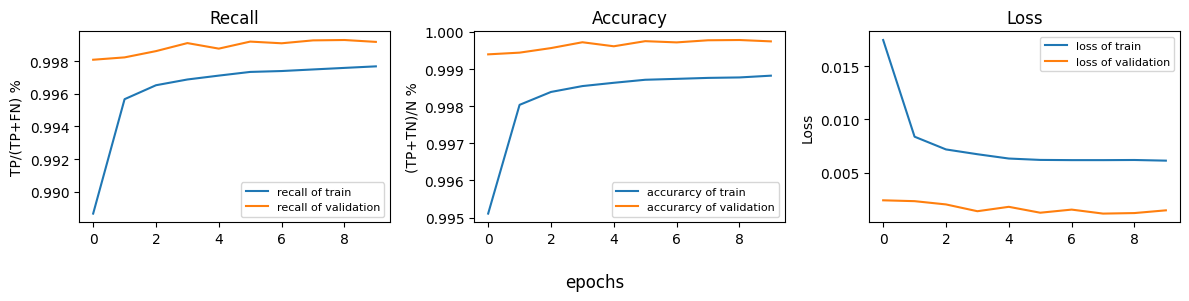

In [224]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [225]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

69640/69640 ━━━━━━━━━━━━━━━━━━━━ 64s 912us/step - accuracy: 0.9998 - auc: 0.9999 - loss: 0.0013 - mse: 2.0841e-04 - precision: 1.0000 - recall: 0.9993
{'accuracy': 0.9997531771659851, 'auc': 0.9998939037322998, 'loss': 0.0013323220191523433, 'mse': 0.00022071295825298876, 'precision': 1.0, 'recall': 0.9992268681526184}


In [226]:
pred_test = model.predict(X_test)
pred_test[:3]

69640/69640 ━━━━━━━━━━━━━━━━━━━━ 22s 315us/step


array([[1.00000000e+00],
       [9.91535425e-01],
       [1.20728645e-08]], dtype=float32)

Text(0.5, 1.0, 'Prediction of False outcome 1517079')

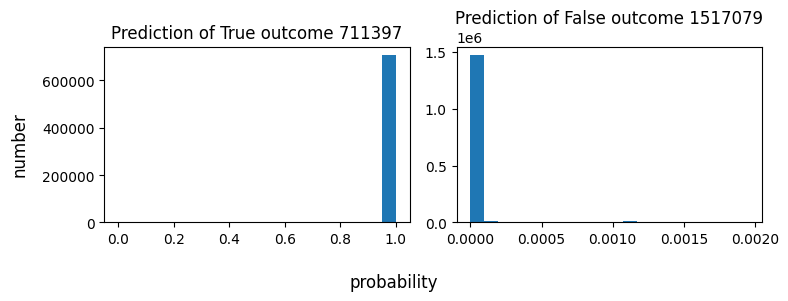

In [227]:

t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of True outcome {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of False outcome {len(f)}')

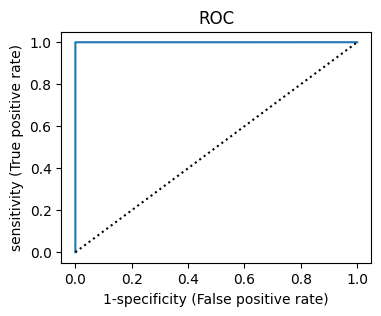

In [229]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
ax.set_title('ROC')
ax.plot([0, 1], [0, 1], 'k:')